In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import gc

In [2]:
train_dir = "../input/dermnet/dermnet_images"

In [3]:
labels_dict = {
    'Acne-and-Rosacea-Photos' : 0,
    'Cellulitis-Impetigo-and-other-Bacterial-Infections' : 1,
    'Eczema-and-Atopic-Dermatitis-Photos' : 2,
    'Nail-Fungus-and-other-Nail-Disease': 3
}

def data_loader():
    #imgs = np.empty(shape=[0, 256, 256, 3])
    images = []
    labels = []
    size = 256,256
    print("Loading...")
    for folder in sorted(os.listdir(train_dir)):
        print(folder)
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            #temp_img = [temp_img]
            images.append(temp_img)
            if folder == 'Acne-and-Rosacea-Photos':
                labels.append(labels_dict['Acne-and-Rosacea-Photos'])
            elif folder == 'Cellulitis-Impetigo-and-other-Bacterial-Infections':
                labels.append(labels_dict['Cellulitis-Impetigo-and-other-Bacterial-Infections'])
            elif folder == 'Eczema-and-Atopic-Dermatitis-Photos':
                labels.append(labels_dict['Eczema-and-Atopic-Dermatitis-Photos'])
            elif folder == 'Nail-Fungus-and-other-Nail-Disease':
                labels.append(labels_dict['Nail-Fungus-and-other-Nail-Disease'])

            #del temp_img, image
            #gc.collect()
    images = np.array(images)
    #images = images.astype('float32')/255.0
    #imgs = np.append(imgs, images, axis=0)
    #del images
    #gc.collect()
    #imgs = np.array(images)
    #print(narr.shape)
    #imgs = np.append(imgs, narr, axis=0)
    print('Total images : ',images.shape[0])
    #del images,narrr 
    #gc.collect()
    
    templabels = labels
    
    labels = to_categorical(labels)
        
    X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.9, random_state=42)
    
    del images, labels
    gc.collect()
    
    return X_train, y_train, X_test, y_test, templabels

In [4]:
X_train, y_train, X_test, y_test, labels = data_loader()

Loading...
Acne-and-Rosacea-Photos
Cellulitis-Impetigo-and-other-Bacterial-Infections
Eczema-and-Atopic-Dermatitis-Photos
Nail-Fungus-and-other-Nail-Disease
Total images :  4700


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.optimizers import SGD
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import math
from math import *
from keras import backend
import tensorflow as tf

class CosineAnnealingLearningRateSchedule(Callback):
    from keras import backend

    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [7]:
#!pip install git+https://github.com/qubvel/efficientnet

In [8]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 1.4 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.2
    Uninstalling pip-20.2.2:
      Successfully uninstalled pip-20.2.2


In [9]:
!pip install -q tensorflow-model-optimization 

In [10]:
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, SpatialDropout2D, BatchNormalization, LeakyReLU, Activation, Lambda
from keras.layers.advanced_activations import LeakyReLU
#from keras.initializers import HeNormal
from keras.applications.vgg16 import VGG16
#from efficientnet.keras import EfficientNetB3
from keras.models import Model
import tensorflow_model_optimization as tfmot
from keras.layers.experimental.preprocessing import Rescaling, Normalization, Resizing
from keras.utils import normalize
#%load_ext tensorboard

def create_model():
    input_shape = (256, 256, 3)
    num_classes = 4

    model = VGG16(weights = 'imagenet', include_top=False, input_shape=input_shape)
    for layer in model.layers:
        layer.trainable = False
    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    
    #initializer = HeNormal()
    flat = Flatten()(model.layers[-1].output)
    #resize = Resizing(32, 256, 256, 3)(flat)
    #scale = Rescaling(scale=1./255)(flat)
    #pre = Lambda(preprocess(flat))
    class1 = Dense(128)(flat)
    #drop1 = Dropout(0.25)(class1)
    act1 = LeakyReLU(alpha=0.1)(class1)
    class2 = Dense(128)(act1)
    #drop2 = Dropout(0.25)(class2)
    act2 = LeakyReLU(alpha=0.1)(class2)
    output = Dense(num_classes, activation='softmax')(act2)
    model = Model(inputs=model.inputs, outputs=output)

    print("MODEL CREATED")
    model.summary()
    return model

In [11]:
cfg = dict(
           batch_size=32,    
           lr_start=5e-5,
           #lr_max=0.0000125,
           #lr_min=0.00001,
           #lr_rampup=5,
           #lr_sustain=0,
           #lr_decay=0.8
        )

In [12]:
from keras.callbacks import LearningRateScheduler

def getLearnRateCallback(cfg):
    
    ''' Using callbacks for learning rate adjustments. '''
    def exp_decay(epoch):
       initial_lrate = cfg['lr_start']
       k = 0.11
       lrate = initial_lrate * exp(-k*epoch)
       return lrate
    
    '''lr_start = cfg['lr_start']
    lr_max = cfg['lr_max'] * cfg['batch_size']
    lr_min = cfg['lr_min']
    lr_rampup = cfg['lr_rampup']
    lr_sustain = cfg['lr_sustain']
    lr_decay = cfg['lr_decay']

    def lrfn(epoch):
        if epoch < lr_rampup:
            lr = (lr_max - lr_start) / lr_rampup * epoch + lr_start
        elif epoch < lr_rampup + lr_sustain:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_rampup -
                                                lr_sustain) + lr_min
        return lr'''

    lr_callback = LearningRateScheduler(exp_decay, verbose=True)
    return lr_callback

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Normalizing and Standardizing test data exactly the same as train data
X_test = X_test.astype('float32')
X_train = X_train.astype('float32')
X_test *= X_test/255.0
X_train *= X_train/255.0

X_test = ((X_test - np.mean(X_test))/(np.std(X_test)))
X_train = ((X_train - np.mean(X_train))/(np.std(X_train)))
#scaler = StandardScaler()
#standardized = scaler.fit_transform(X_test)
#X_test = scaler.inverse_transform(standardized)
#normalized = scaler.fit_transform(X_test)
#X_test = scaler.inverse_transform(normalized)

'''mean = np.mean(X_test, axis=(0, 1, 2))
broadcast_shape = [1, 1, 1]
broadcast_shape[2] = X_test.shape[3]
mean = np.reshape(mean, broadcast_shape)
X_test -= mean

std = np.std(X_test, axis=(0, 1, 2))
broadcast_shape = [1, 1, 1]
broadcast_shape[2] = X_test.shape[3]
std = np.reshape(std, broadcast_shape)
X_test /= (std + 1e-6)'''

train_datagen = ImageDataGenerator(
        #rescale=1./255,
        #featurewise_center=True,
        samplewise_center=False,
        #featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=40,
        shear_range = 0.1,
        zoom_range = 0.3,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
)
train_datagen.fit(X_train)

def preprocess(x):
    #x = tf.make_tensor_proto(x)
    #x = tf.make_ndarray(x)
    x=x.numpy()
    print(type(x))
    x *= x/255.0
    #mean = np.mean(x)
    #std = np.std(x)
    #x = (x - mean)/std
    scaler = StandardScaler()
    standardized = scaler.fit_transform(x)
    x = scaler.inverse_transform(standardized)
    normalized = scaler.fit_transform(x)
    x = scaler.inverse_transform(normalized)
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    return x

In [14]:
train_iterator = train_datagen.flow(X_train, y_train, subset='training', batch_size=cfg['batch_size'])
val_iterator = train_datagen.flow(X_train, y_train, subset='validation', batch_size=cfg['batch_size'])

In [15]:
from keras.callbacks import EarlyStopping
import datetime
def fit_model():
    n_epochs = 200
    #n_cycles = n_epochs/20
    #ca = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, 0.001, verbose=1), getLearnRateCallback(cfg)
    #logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
                 #tfmot.sparsity.keras.PruningSummaries(log_dir=logdir, profile_batch=0),
                 #getLearnRateCallback(cfg),
                 EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min'),
                 ModelCheckpoint('weights_best.hdf5',
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 #save_weights_only=False,
                                 mode='max'
                                )
                ]    
    pruning_schedule = tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5,
        begin_step=2000, end_step=4000)

    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(
        model, pruning_schedule=pruning_schedule)
    
    sgd = SGD(lr=1e-4, momentum = 0.9, nesterov = True)
    #adam = Adam(learning_rate=1e-4)
    rmsprop = RMSprop(learning_rate=3e-4)
    adad = Adadelta()
    
    model_for_pruning.compile(loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=5e-5),
            metrics=['accuracy'])
    
    model_hist = model_for_pruning.fit(train_iterator, epochs = n_epochs, callbacks = callbacks,  validation_data = val_iterator, verbose=1)
    return model_hist, model_for_pruning

In [16]:
model = create_model()
curr_model_hist, model = fit_model()

58892288/58889256 [==============================] - 0s 0us/step
MODEL CREATED
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________

Epoch 15/200
106/106 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8945
Epoch 00015: val_accuracy improved from 0.83097 to 0.83924, saving model to weights_best.hdf5
106/106 [==============================] - 65s 615ms/step - loss: 0.2802 - accuracy: 0.8945 - val_loss: 0.4853 - val_accuracy: 0.8392
Epoch 16/200
106/106 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9105
Epoch 00016: val_accuracy did not improve from 0.83924
106/106 [==============================] - 65s 612ms/step - loss: 0.2400 - accuracy: 0.9105 - val_loss: 0.5184 - val_accuracy: 0.8156
Epoch 17/200
106/106 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9051
Epoch 00017: val_accuracy did not improve from 0.83924
106/106 [==============================] - 65s 609ms/step - loss: 0.2554 - accuracy: 0.9051 - val_loss: 0.5794 - val_accuracy: 0.8014
Epoch 18/200
106/106 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9164
Ep

In [17]:
#curr_model_hist.history

In [18]:
model.load_weights('weights_best.hdf5')

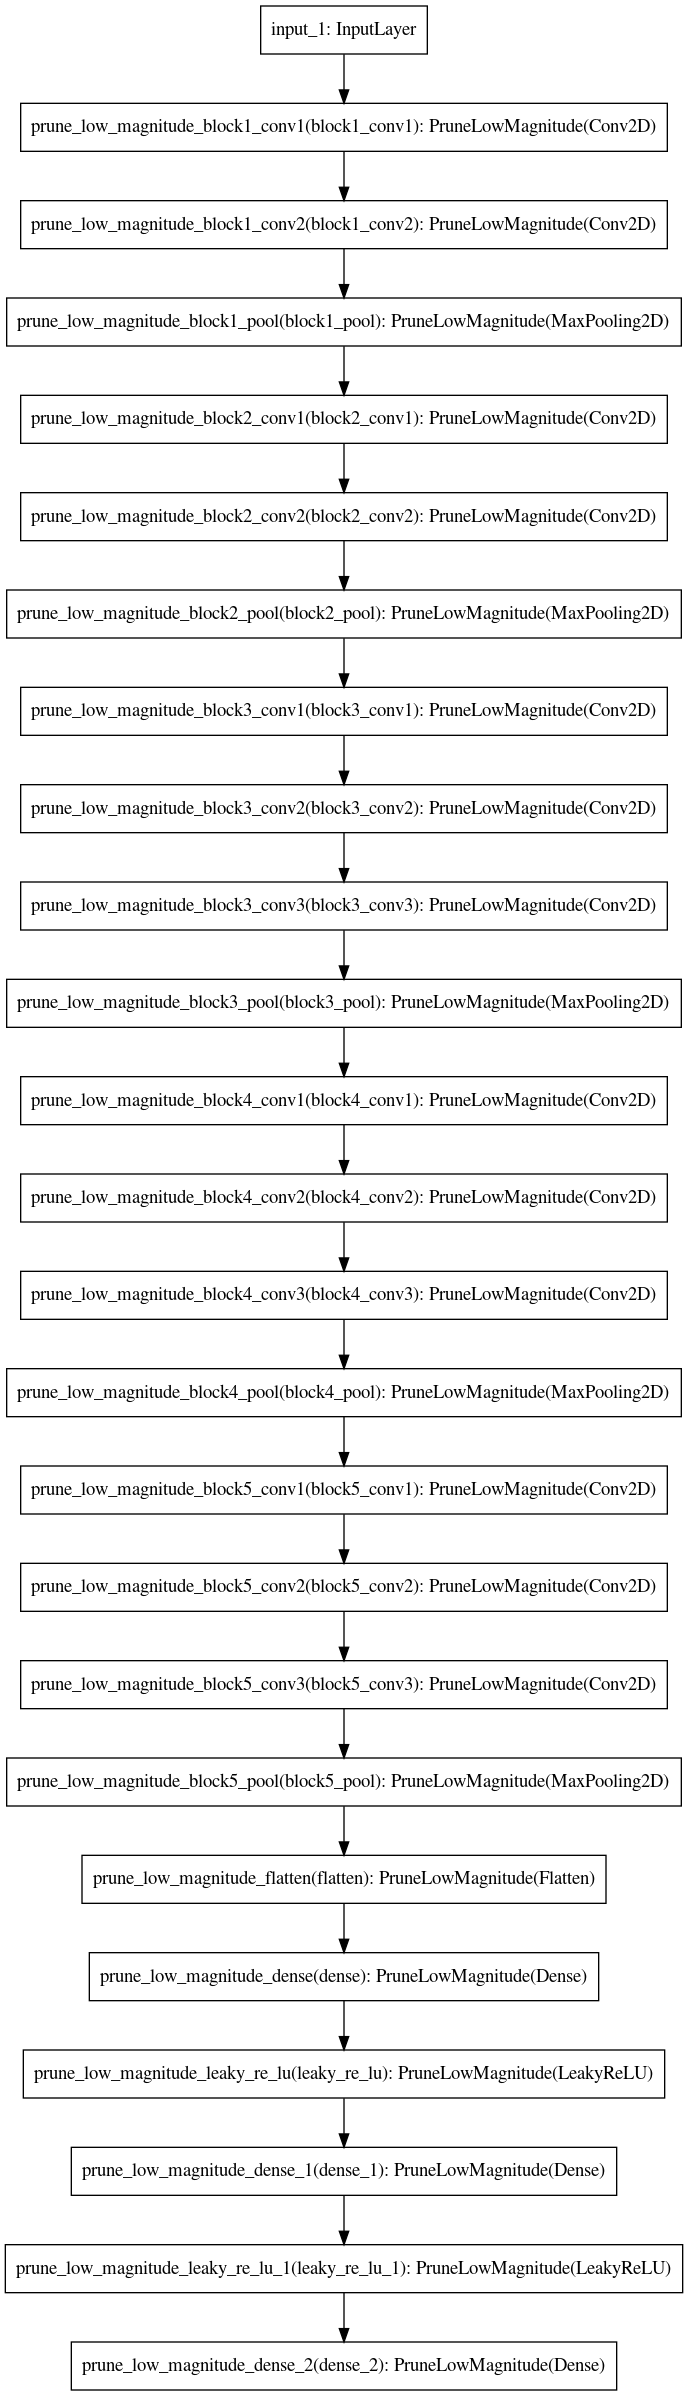

In [19]:
keras.utils.plot_model(model, "model.png")

In [20]:
#from tensorboard import notebook
#notebook.list()

In [21]:
#notebook.display(port=6006, height=1000) 

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=cfg['batch_size'])
print("\nTest Accuracy = ", "{:.2f}%".format(test_acc*100),"\nTest Loss = " ,"{:.6f}".format(test_loss))

15/15 [==============================] - 2s 112ms/step - loss: 0.5999 - accuracy: 0.8298

Test Accuracy =  82.98% 
Test Loss =  0.599922


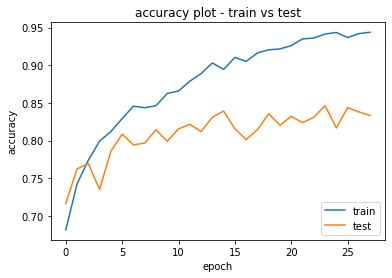

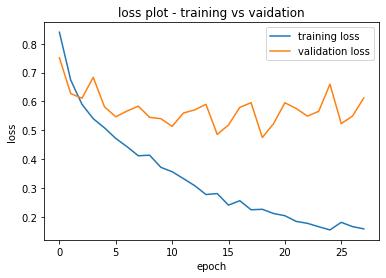

In [23]:
def plot_accuracy(y):
    if(y == True):
        plt.plot(curr_model_hist.history['accuracy'])
        plt.plot(curr_model_hist.history['val_accuracy'])
        plt.legend(['train', 'test'], loc='lower right')
        plt.title('accuracy plot - train vs test')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    else:
        pass
    return

def plot_loss(y):
    if(y == True):
        plt.plot(curr_model_hist.history['loss'])
        plt.plot(curr_model_hist.history['val_loss'])
        plt.legend(['training loss', 'validation loss'], loc = 'upper right')
        plt.title('loss plot - training vs vaidation')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    else:
        pass
    return


plot_accuracy(True)
plot_loss(True)

In [24]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred = to_categorical(y_pred)

In [25]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score: ",roc_auc_score(y_test, y_pred))

ROC AUC Score:  0.8378809180596807


In [26]:
from sklearn.metrics import f1_score
from sklearn import metrics
from numpy import argmax

print(metrics.classification_report(y_test.argmax(axis = 1), y_pred.argmax(axis = 1), digits=3))

              precision    recall  f1-score   support

           0      0.798     0.858     0.827       106
           1      0.333     0.306     0.319        36
           2      0.853     0.831     0.842       189
           3      0.942     0.942     0.942       139

    accuracy                          0.830       470
   macro avg      0.732     0.734     0.733       470
weighted avg      0.827     0.830     0.828       470



In [27]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[ 91,   5,   9,   1],
       [ 10,  11,  12,   3],
       [ 12,  16, 157,   4],
       [  1,   1,   6, 131]])

In [28]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model)

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_model = converter.convert()

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_pruned_model = converter.convert()

open("quantized_pruned_model_tflite.tflite", "wb").write(quantized_pruned_model)
open("pruned_model_tflite.tflite", "wb").write(pruned_model)

print("TFlite file generated")

TFlite file generated


In [29]:
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(X_test):
    if i % 1000 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)
  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  prediction_digits = to_categorical(prediction_digits)
  print(metrics.classification_report(y_test.argmax(axis = 1), prediction_digits.argmax(axis = 1), digits=3))

print('Pruned TFLite test accuracy:')
interpreter = tf.lite.Interpreter(model_content=pruned_model)
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Pruned and Quantized TFLite test accuracy:')
interpreter = tf.lite.Interpreter(model_content=quantized_pruned_model)
interpreter.allocate_tensors()
test_accuracy_quantized = evaluate_model(interpreter)

Pruned TFLite test accuracy:
Evaluated on 0 results so far.


              precision    recall  f1-score   support

           0      0.798     0.858     0.827       106
           1      0.333     0.306     0.319        36
           2      0.853     0.831     0.842       189
           3      0.942     0.942     0.942       139

    accuracy                          0.830       470
   macro avg      0.732     0.734     0.733       470
weighted avg      0.827     0.830     0.828       470

Pruned and Quantized TFLite test accuracy:
Evaluated on 0 results so far.


              precision    recall  f1-score   support

           0      0.784     0.858     0.820       106
           1      0.333     0.333     0.333        36
           2      0.850     0.810     0.829       189
           3      0.935     0.928     0.931       139

    accuracy                          0.819       470
   macro avg      0.726     0.732     0.728       470
weighted avg      0.821     0.819     0.819    